# Bitcoin Price Model для Polymarket

Модель распределения цены BTC на основе:
- Исторической волатильности (σ)
- Толстых хвостов (Student-t вместо нормального распределения)
- Нескольких гипотез о матожидании (μ)
- Monte Carlo симуляции

Цель: получить fair prices для контрактов Polymarket и найти edge.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
from datetime import datetime, timedelta
import yfinance as yf
import requests
import json
import re

plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (14, 6)
plt.rcParams['font.size'] = 12

np.random.seed(42)

## 1. Загрузка исторических данных BTC

[*********************100%***********************]  1 of 1 completed


Период: 2015-01-02 — 2026-02-07
Дней: 4054
Текущая цена: $70,797
ATH: $124,753


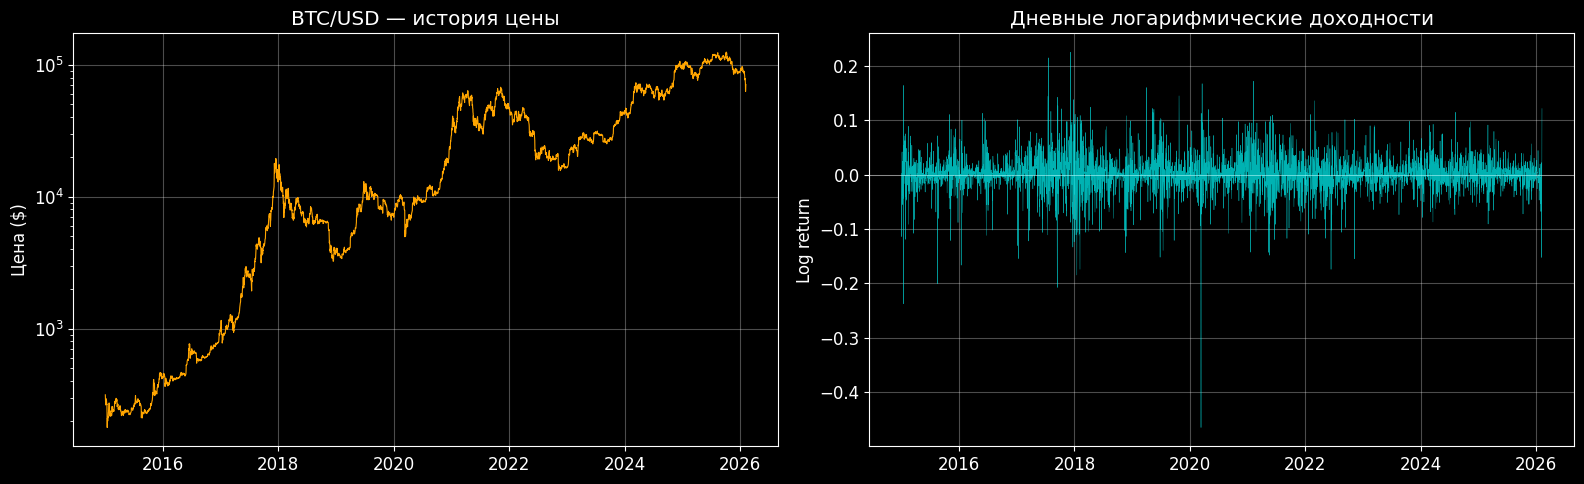

In [2]:
# Скачиваем дневные данные BTC с 2015 до сегодня
btc = yf.download('BTC-USD', start='2015-01-01', auto_adjust=True)
btc = btc[['Close']].dropna()
btc.columns = ['price']

# Дневные логарифмические доходности
btc['log_return'] = np.log(btc['price'] / btc['price'].shift(1))
btc = btc.dropna()

print(f"Период: {btc.index[0].date()} — {btc.index[-1].date()}")
print(f"Дней: {len(btc)}")
print(f"Текущая цена: ${btc['price'].iloc[-1]:,.0f}")
print(f"ATH: ${btc['price'].max():,.0f}")

# График цены
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

ax1.plot(btc.index, btc['price'], color='orange', linewidth=0.8)
ax1.set_title('BTC/USD — история цены')
ax1.set_ylabel('Цена ($)')
ax1.set_yscale('log')
ax1.grid(alpha=0.3)

ax2.plot(btc.index, btc['log_return'], color='cyan', linewidth=0.3, alpha=0.7)
ax2.set_title('Дневные логарифмические доходности')
ax2.set_ylabel('Log return')
ax2.axhline(y=0, color='white', linewidth=0.5, alpha=0.5)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 2. Анализ распределения доходностей

Сравним реальное распределение с нормальным — увидим толстые хвосты.

=== Статистика дневных доходностей ===
Среднее (daily):  0.001336 (0.1336%)
Std dev (daily):  0.035500 (3.5500%)

Среднее (annual): 0.4878 (48.78%)
Std dev (annual): 0.6782 (67.82%)

Skewness:  -0.7395
Kurtosis:  11.8985 (нормальное = 0, >0 = толстые хвосты)


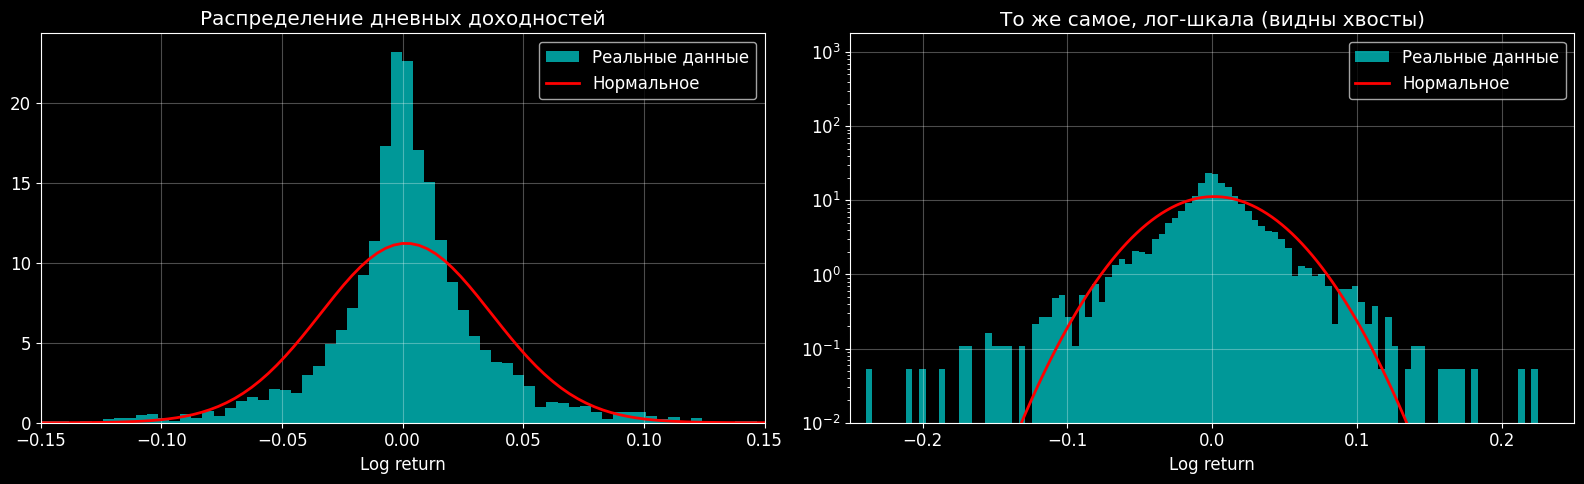

In [3]:
returns = btc['log_return'].values

# Базовая статистика
daily_mu = returns.mean()
daily_sigma = returns.std()
annual_mu = daily_mu * 365
annual_sigma = daily_sigma * np.sqrt(365)

print("=== Статистика дневных доходностей ===")
print(f"Среднее (daily):  {daily_mu:.6f} ({daily_mu*100:.4f}%)")
print(f"Std dev (daily):  {daily_sigma:.6f} ({daily_sigma*100:.4f}%)")
print(f"")
print(f"Среднее (annual): {annual_mu:.4f} ({annual_mu*100:.2f}%)")
print(f"Std dev (annual): {annual_sigma:.4f} ({annual_sigma*100:.2f}%)")
print(f"")
print(f"Skewness:  {stats.skew(returns):.4f}")
print(f"Kurtosis:  {stats.kurtosis(returns):.4f} (нормальное = 0, >0 = толстые хвосты)")

# Гистограмма + нормальное распределение
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Линейная шкала
x = np.linspace(returns.min(), returns.max(), 200)
ax1.hist(returns, bins=150, density=True, alpha=0.6, color='cyan', label='Реальные данные')
ax1.plot(x, stats.norm.pdf(x, daily_mu, daily_sigma), 'r-', linewidth=2, label='Нормальное')
ax1.set_title('Распределение дневных доходностей')
ax1.set_xlabel('Log return')
ax1.legend()
ax1.set_xlim(-0.15, 0.15)
ax1.grid(alpha=0.3)

# Логарифмическая шкала (хвосты видны лучше)
ax2.hist(returns, bins=150, density=True, alpha=0.6, color='cyan', label='Реальные данные')
ax2.plot(x, stats.norm.pdf(x, daily_mu, daily_sigma), 'r-', linewidth=2, label='Нормальное')
ax2.set_title('То же самое, лог-шкала (видны хвосты)')
ax2.set_xlabel('Log return')
ax2.set_yscale('log')
ax2.legend()
ax2.set_xlim(-0.25, 0.25)
ax2.set_ylim(0.01, None)
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 3. Подгонка Student-t распределения

Student-t лучше описывает толстые хвосты BTC. Параметр `df` (degrees of freedom) — чем меньше, тем толще хвосты.

Student-t параметры:
  df (степени свободы): 2.17  (< 5 = очень толстые хвосты)
  loc (центр):          0.001548
  scale (масштаб):      0.018482


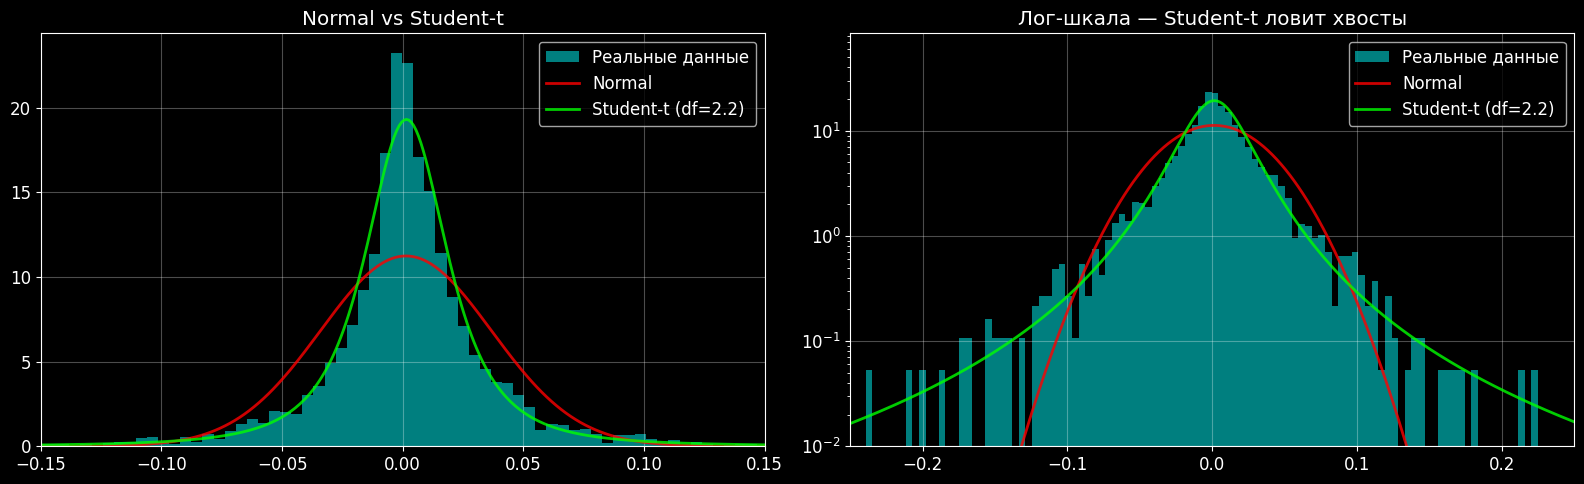

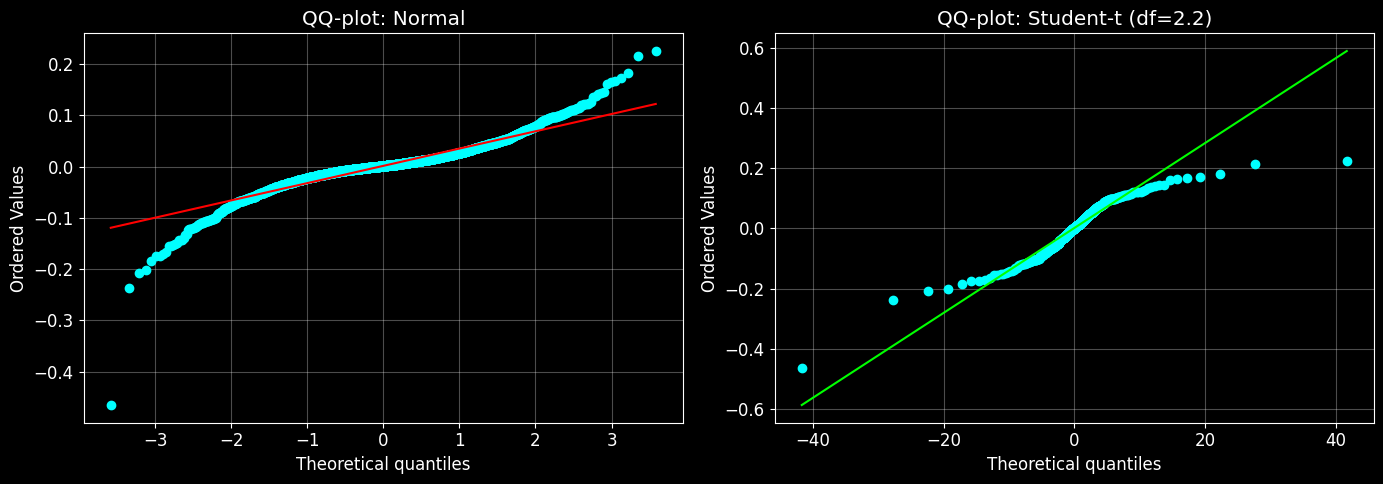

In [4]:
# Подгоняем Student-t
t_params = stats.t.fit(returns)
t_df, t_loc, t_scale = t_params

print(f"Student-t параметры:")
print(f"  df (степени свободы): {t_df:.2f}  (< 5 = очень толстые хвосты)")
print(f"  loc (центр):          {t_loc:.6f}")
print(f"  scale (масштаб):      {t_scale:.6f}")

# Сравнение: Normal vs Student-t vs реальные данные
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

x = np.linspace(-0.25, 0.25, 500)

ax1.hist(returns, bins=150, density=True, alpha=0.5, color='cyan', label='Реальные данные')
ax1.plot(x, stats.norm.pdf(x, daily_mu, daily_sigma), 'r-', linewidth=2, label='Normal', alpha=0.8)
ax1.plot(x, stats.t.pdf(x, *t_params), 'lime', linewidth=2, label=f'Student-t (df={t_df:.1f})', alpha=0.8)
ax1.set_title('Normal vs Student-t')
ax1.set_xlim(-0.15, 0.15)
ax1.legend()
ax1.grid(alpha=0.3)

# Лог-шкала — хвосты
ax2.hist(returns, bins=150, density=True, alpha=0.5, color='cyan', label='Реальные данные')
ax2.plot(x, stats.norm.pdf(x, daily_mu, daily_sigma), 'r-', linewidth=2, label='Normal', alpha=0.8)
ax2.plot(x, stats.t.pdf(x, *t_params), 'lime', linewidth=2, label=f'Student-t (df={t_df:.1f})', alpha=0.8)
ax2.set_title('Лог-шкала — Student-t ловит хвосты')
ax2.set_yscale('log')
ax2.set_xlim(-0.25, 0.25)
ax2.set_ylim(0.01, None)
ax2.legend()
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# QQ-plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

stats.probplot(returns, dist='norm', plot=ax1)
ax1.set_title('QQ-plot: Normal')
ax1.get_lines()[0].set_color('cyan')
ax1.get_lines()[1].set_color('red')
ax1.grid(alpha=0.3)

stats.probplot(returns, dist=stats.t, sparams=(t_df,), plot=ax2)
ax2.set_title(f'QQ-plot: Student-t (df={t_df:.1f})')
ax2.get_lines()[0].set_color('cyan')
ax2.get_lines()[1].set_color('lime')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Monte Carlo симуляция

Параметры:
- **σ**: из исторических данных (Student-t)
- **μ**: несколько гипотез — мы НЕ ЗНАЕМ матожидание, поэтому пробуем разные
- **Горизонт**: до конца 2026 (динамически от сегодня)
- **Контракты**: "BTC достигнет $X хотя бы раз" (touch probability)

In [5]:
# Параметры симуляции
CURRENT_PRICE = btc['price'].iloc[-1]
DAYS_LEFT = (datetime(2027, 1, 1) - datetime.now()).days
N_SIMULATIONS = 50_000

# Гипотезы о годовом матожидании
MU_HYPOTHESES = {
    'Медвежий (μ=-30%)': -0.30,
    'Стагнация (μ=0%)':   0.00,
    'Умеренный (μ=+30%)': 0.30,
    'Бычий (μ=+70%)':     0.70,
    'Ралли (μ=+150%)':    1.50,
}

# Веса гипотез (наше prior belief — можно менять)
MU_WEIGHTS = {
    'Медвежий (μ=-30%)':  0.20,
    'Стагнация (μ=0%)':   0.30,
    'Умеренный (μ=+30%)': 0.25,
    'Бычий (μ=+70%)':     0.15,
    'Ралли (μ=+150%)':    0.10,
}

print(f"Текущая цена BTC: ${CURRENT_PRICE:,.0f}")
print(f"Дата: {datetime.now().strftime('%Y-%m-%d')}")
print(f"Дней до конца 2026: {DAYS_LEFT}")
print(f"Симуляций на гипотезу: {N_SIMULATIONS:,}")
print(f"Всего траекторий: {N_SIMULATIONS * len(MU_HYPOTHESES):,}")
print(f"\nГипотезы:")
for name, mu in MU_HYPOTHESES.items():
    w = MU_WEIGHTS[name]
    print(f"  {name:25s}  вес={w:.0%}")

Текущая цена BTC: $70,797
Дата: 2026-02-07
Дней до конца 2026: 327
Симуляций на гипотезу: 50,000
Всего траекторий: 250,000

Гипотезы:
  Медвежий (μ=-30%)          вес=20%
  Стагнация (μ=0%)           вес=30%
  Умеренный (μ=+30%)         вес=25%
  Бычий (μ=+70%)             вес=15%
  Ралли (μ=+150%)            вес=10%


In [6]:
def simulate_paths(current_price, days, n_sims, annual_mu, t_df, t_scale):
    """
    Monte Carlo симуляция ценовых траекторий.
    Использует Student-t распределение для дневных доходностей.

    Возвращает матрицу (n_sims, days) с ценами.
    """
    daily_drift = annual_mu / 365

    # Генерируем случайные доходности из Student-t
    # t_scale уже подогнан к историческим данным
    random_returns = stats.t.rvs(df=t_df, loc=daily_drift, scale=t_scale,
                                  size=(n_sims, days))

    # Кумулятивные доходности → цены
    cum_returns = np.cumsum(random_returns, axis=1)
    paths = current_price * np.exp(cum_returns)

    return paths


# Запускаем симуляции для каждой гипотезы
results = {}
all_paths = {}

for name, mu in MU_HYPOTHESES.items():
    paths = simulate_paths(CURRENT_PRICE, DAYS_LEFT, N_SIMULATIONS, mu, t_df, t_scale)
    all_paths[name] = paths
    results[name] = {
        'max_price': np.max(paths, axis=1),   # максимум на траектории (для touch prob)
        'min_price': np.min(paths, axis=1),   # минимум на траектории
        'final_price': paths[:, -1],           # цена в конце 2026
    }

print("Симуляция завершена!")

Симуляция завершена!


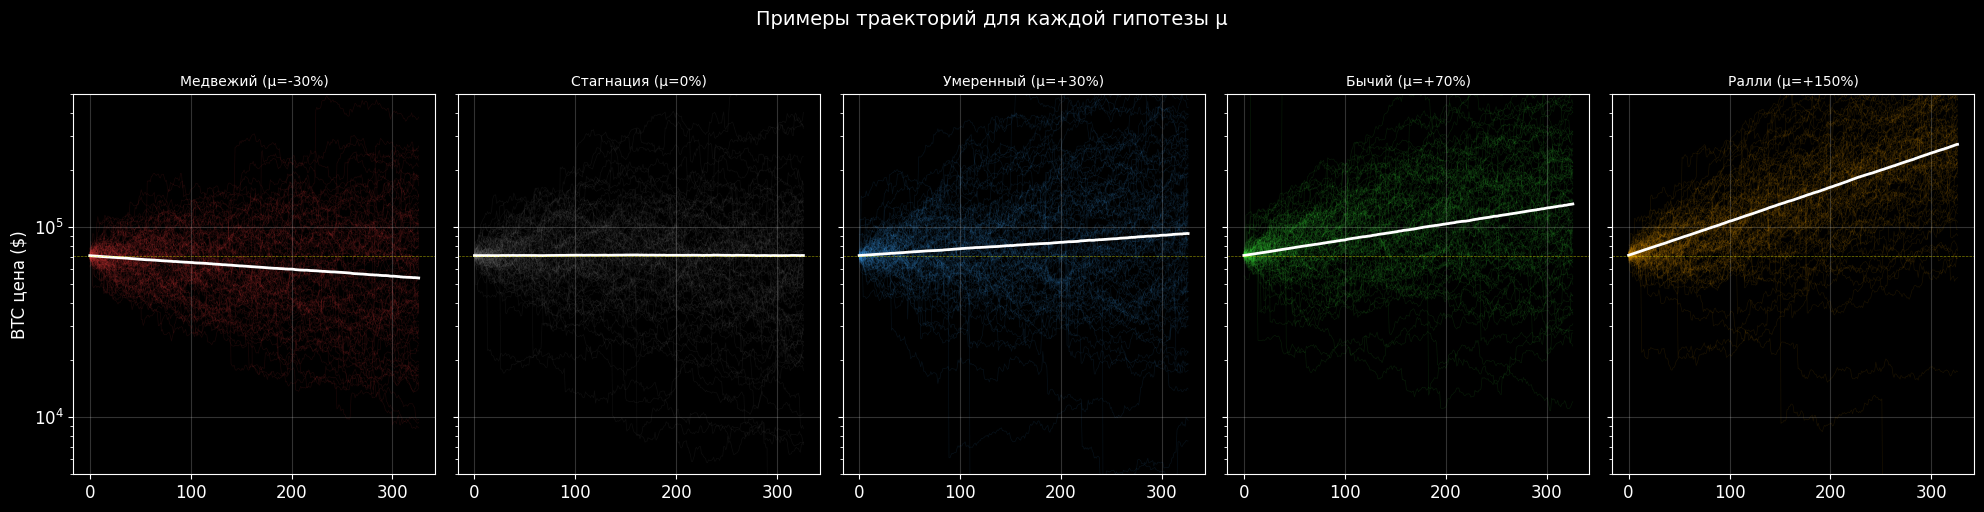

In [7]:
# Визуализация: примеры траекторий для каждой гипотезы
fig, axes = plt.subplots(1, len(MU_HYPOTHESES), figsize=(20, 5), sharey=True)
colors = ['#ff4444', '#888888', '#44aaff', '#44ff44', '#ffaa00']

for idx, (name, paths) in enumerate(all_paths.items()):
    ax = axes[idx]
    # Показываем 100 случайных траекторий
    sample_idx = np.random.choice(N_SIMULATIONS, 100, replace=False)
    for i in sample_idx:
        ax.plot(paths[i], color=colors[idx], alpha=0.1, linewidth=0.5)

    # Медиана
    median_path = np.median(paths, axis=0)
    ax.plot(median_path, color='white', linewidth=2, label='Медиана')

    ax.axhline(y=CURRENT_PRICE, color='yellow', linewidth=0.5, linestyle='--', alpha=0.5)
    ax.set_title(name, fontsize=10)
    ax.set_yscale('log')
    ax.set_ylim(5000, 500000)
    ax.grid(alpha=0.2)
    if idx == 0:
        ax.set_ylabel('BTC цена ($)')

fig.suptitle('Примеры траекторий для каждой гипотезы μ', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 5. Вероятности достижения ценовых уровней

Polymarket спрашивает: "BTC **достигнет** $X до 2027?" — это touch probability (максимум/минимум на траектории).

In [8]:
# Загружаем цены с Polymarket API (контракт: "What price will Bitcoin hit before 2027?")
PM_EVENT_SLUG = "what-price-will-bitcoin-hit-before-2027"

def fetch_polymarket_prices(slug):
    """Тянет текущие цены контрактов с Polymarket API."""
    url = f"https://gamma-api.polymarket.com/events?slug={slug}"
    resp = requests.get(url, timeout=10)
    resp.raise_for_status()
    data = resp.json()

    prices = {'up': {}, 'down': {}}
    for m in data[0]['markets']:
        title = m.get('groupItemTitle', '')
        outcome_prices = json.loads(m['outcomePrices'])
        yes_price = float(outcome_prices[0])

        # Пропускаем уже зарезолвленные (YES ≈ 1.0 или ≈ 0.0)
        if yes_price >= 0.95 or yes_price <= 0.005:
            continue

        # Парсим направление и уровень: "↑ 150,000" или "↓ 30,000"
        match = re.match(r'([↑↓])\s+([\d,]+)', title)
        if not match:
            continue

        direction = 'up' if match.group(1) == '↑' else 'down'
        level = int(match.group(2).replace(',', ''))

        # Если дубликат уровня (бывает) — берём не-резолвленный
        if level not in prices[direction]:
            prices[direction][level] = yes_price

    return prices

try:
    POLYMARKET_PRICES = fetch_polymarket_prices(PM_EVENT_SLUG)
    print("✅ Цены загружены с Polymarket API")
except Exception as e:
    print(f"⚠️ Ошибка API: {e}")
    print("Используем захардкоженные цены (fallback)")
    POLYMARKET_PRICES = {
        'up': {250_000: 0.042, 200_000: 0.08, 150_000: 0.11, 140_000: 0.15,
               130_000: 0.17, 120_000: 0.21, 110_000: 0.31, 100_000: 0.44},
        'down': {55_000: 0.72, 50_000: 0.57, 45_000: 0.42, 40_000: 0.36,
                 35_000: 0.25, 30_000: 0.24, 25_000: 0.15, 20_000: 0.12,
                 15_000: 0.089, 10_000: 0.07}
    }

# Показываем загруженные цены
print(f"\nДата: {datetime.now().strftime('%Y-%m-%d %H:%M')}")
print(f"\n▲ Рост (BTC коснётся уровня):")
for level in sorted(POLYMARKET_PRICES['up'].keys()):
    print(f"  BTC > ${level:>7,}:  {POLYMARKET_PRICES['up'][level]:.1%}")

print(f"\n▼ Падение (BTC коснётся уровня):")
for level in sorted(POLYMARKET_PRICES['down'].keys(), reverse=True):
    print(f"  BTC < ${level:>7,}:  {POLYMARKET_PRICES['down'][level]:.1%}")

# Считаем touch probabilities для каждой гипотезы
print(f"\n{'':30s}", end='')
for name in MU_HYPOTHESES:
    short = name.split('(')[0].strip()
    print(f"{short:>12s}", end='')
print(f"{'Взвешенное':>12s}  {'Polymarket':>11s}  {'Edge':>7s}")
print("=" * 120)

edges = []

# Уровни вверх
print("\n  ▲ Рост (touch max)")
for level in sorted(POLYMARKET_PRICES['up'].keys()):
    pm_price = POLYMARKET_PRICES['up'][level]
    probs = []
    print(f"  BTC > ${level:>7,}:  ", end='')
    for name in MU_HYPOTHESES:
        p = np.mean(results[name]['max_price'] >= level)
        probs.append(p)
        print(f"{p:>11.1%} ", end='')

    weights = list(MU_WEIGHTS.values())
    weighted = sum(p * w for p, w in zip(probs, weights))
    edge = weighted - pm_price
    edges.append(('up', level, weighted, pm_price, edge))

    edge_color = '🟢' if edge > 0.03 else ('🔴' if edge < -0.03 else '⚪')
    print(f"{weighted:>11.1%}  {pm_price:>10.1%}  {edge:>+6.1%} {edge_color}")

# Уровни вниз
print("\n  ▼ Падение (touch min)")
for level in sorted(POLYMARKET_PRICES['down'].keys(), reverse=True):
    pm_price = POLYMARKET_PRICES['down'][level]
    probs = []
    print(f"  BTC < ${level:>7,}:  ", end='')
    for name in MU_HYPOTHESES:
        p = np.mean(results[name]['min_price'] <= level)
        probs.append(p)
        print(f"{p:>11.1%} ", end='')

    weights = list(MU_WEIGHTS.values())
    weighted = sum(p * w for p, w in zip(probs, weights))
    edge = weighted - pm_price
    edges.append(('down', level, weighted, pm_price, edge))

    edge_color = '🟢' if edge > 0.03 else ('🔴' if edge < -0.03 else '⚪')
    print(f"{weighted:>11.1%}  {pm_price:>10.1%}  {edge:>+6.1%} {edge_color}")

print("\n🟢 = модель выше рынка (покупать YES), 🔴 = модель ниже рынка (покупать NO)")

✅ Цены загружены с Polymarket API

Дата: 2026-02-07 11:31

▲ Рост (BTC коснётся уровня):
  BTC > $ 75,000:  83.5%
  BTC > $ 80,000:  74.0%
  BTC > $ 90,000:  62.0%
  BTC > $100,000:  45.5%
  BTC > $110,000:  33.5%
  BTC > $120,000:  21.5%
  BTC > $130,000:  17.0%
  BTC > $140,000:  14.5%
  BTC > $150,000:  10.5%
  BTC > $160,000:  10.0%
  BTC > $170,000:  8.0%
  BTC > $180,000:  7.5%
  BTC > $190,000:  8.0%
  BTC > $200,000:  7.0%
  BTC > $250,000:  4.8%

▼ Падение (BTC коснётся уровня):
  BTC < $ 55,000:  68.5%
  BTC < $ 50,000:  58.5%
  BTC < $ 45,000:  41.0%
  BTC < $ 40,000:  34.5%
  BTC < $ 35,000:  23.0%
  BTC < $ 30,000:  19.0%
  BTC < $ 25,000:  10.0%
  BTC < $ 20,000:  9.0%
  BTC < $ 15,000:  6.7%
  BTC < $ 10,000:  5.5%
  BTC < $  5,000:  3.6%

                                  Медвежий   Стагнация   Умеренный       Бычий       Ралли  Взвешенное   Polymarket     Edge

  ▲ Рост (touch max)
  BTC > $ 75,000:        84.5%       89.4%       93.1%       96.7%       99.3%       91.

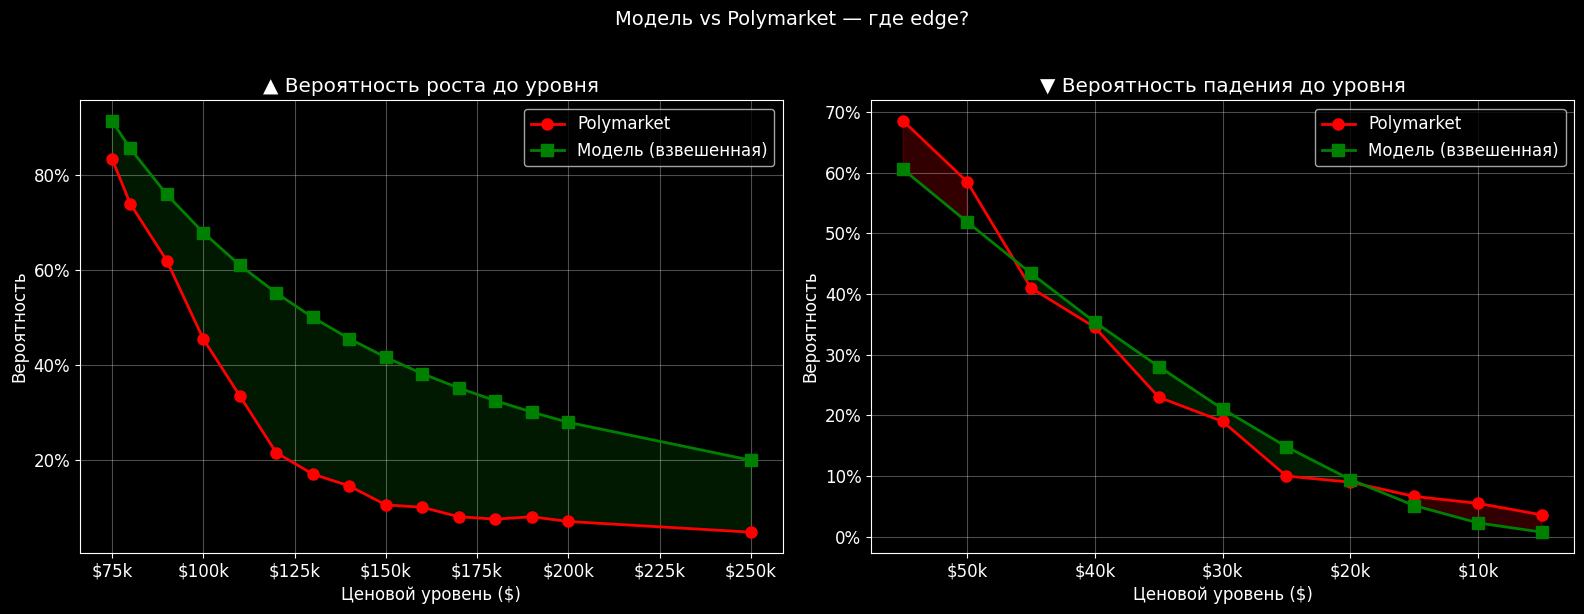

In [9]:
# График: Модель vs Polymarket
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Уровни вверх
up_levels = sorted(POLYMARKET_PRICES['up'].keys())
up_pm = [POLYMARKET_PRICES['up'][l] for l in up_levels]
up_model = []
for l in up_levels:
    e = [x for x in edges if x[0] == 'up' and x[1] == l][0]
    up_model.append(e[2])

ax1.plot(up_levels, up_pm, 'ro-', linewidth=2, markersize=8, label='Polymarket')
ax1.plot(up_levels, up_model, 'gs-', linewidth=2, markersize=8, label='Модель (взвешенная)')
ax1.fill_between(up_levels, up_pm, up_model, alpha=0.2,
                  color='green', where=[m > p for m, p in zip(up_model, up_pm)])
ax1.fill_between(up_levels, up_pm, up_model, alpha=0.2,
                  color='red', where=[m < p for m, p in zip(up_model, up_pm)])
ax1.set_title('▲ Вероятность роста до уровня')
ax1.set_xlabel('Ценовой уровень ($)')
ax1.set_ylabel('Вероятность')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

# Уровни вниз
dn_levels = sorted(POLYMARKET_PRICES['down'].keys(), reverse=True)
dn_pm = [POLYMARKET_PRICES['down'][l] for l in dn_levels]
dn_model = []
for l in dn_levels:
    e = [x for x in edges if x[0] == 'down' and x[1] == l][0]
    dn_model.append(e[2])

ax2.plot(dn_levels, dn_pm, 'ro-', linewidth=2, markersize=8, label='Polymarket')
ax2.plot(dn_levels, dn_model, 'gs-', linewidth=2, markersize=8, label='Модель (взвешенная)')
ax2.fill_between(dn_levels, dn_pm, dn_model, alpha=0.2,
                  color='green', where=[m > p for m, p in zip(dn_model, dn_pm)])
ax2.fill_between(dn_levels, dn_pm, dn_model, alpha=0.2,
                  color='red', where=[m < p for m, p in zip(dn_model, dn_pm)])
ax2.set_title('▼ Вероятность падения до уровня')
ax2.set_xlabel('Ценовой уровень ($)')
ax2.set_ylabel('Вероятность')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

fig.suptitle('Модель vs Polymarket — где edge?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 6. Implied vs Model Distribution

Извлекаем подразумеваемое распределение из цен Polymarket и сравниваем с нашей моделью.

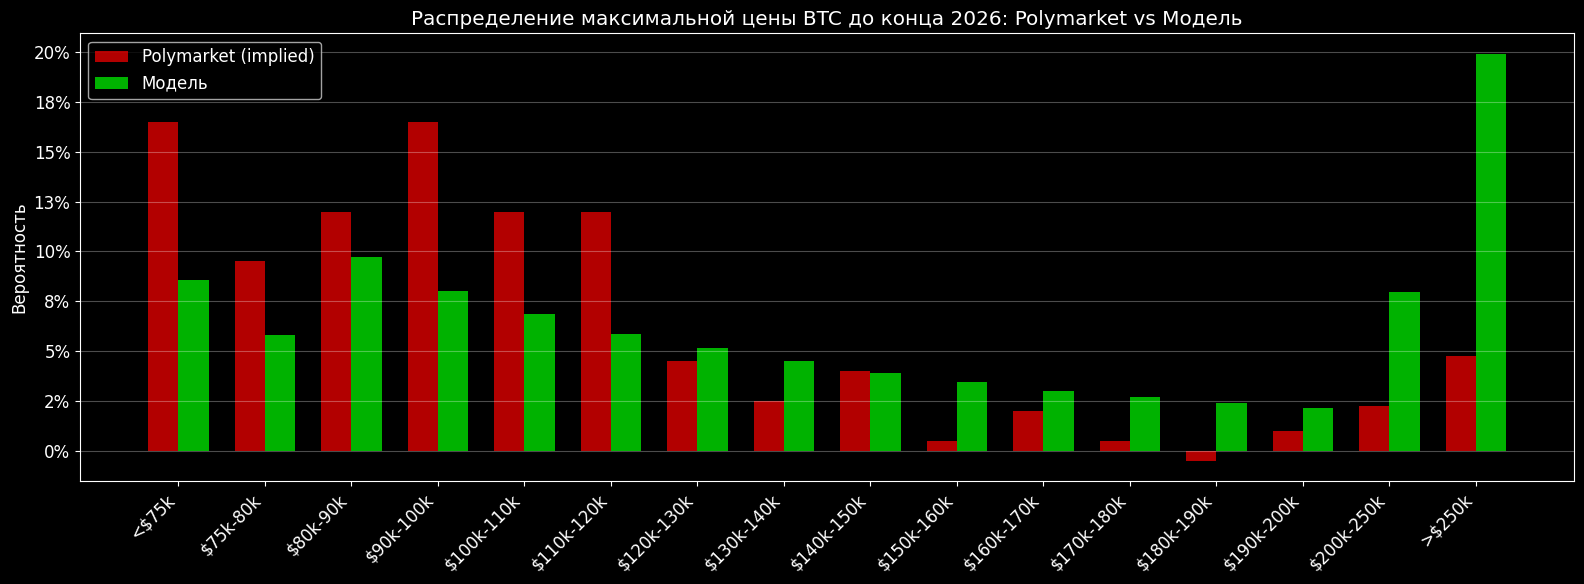

In [10]:
# Implied distribution из цен Polymarket
# Для уровней вверх: P(max >= L) даёт 1-CDF хвост
# Для промежутков: P(L1 < max < L2) = P(max >= L1) - P(max >= L2)

all_levels_up = sorted(POLYMARKET_PRICES['up'].keys())
all_levels_dn = sorted(POLYMARKET_PRICES['down'].keys(), reverse=True)

# Строим implied density для max price (upside)
implied_ranges_up = []
for i in range(len(all_levels_up)):
    if i == 0:
        p = 1.0 - POLYMARKET_PRICES['up'][all_levels_up[0]]  # ниже первого уровня
    else:
        p = POLYMARKET_PRICES['up'][all_levels_up[i-1]] - POLYMARKET_PRICES['up'][all_levels_up[i]]
    implied_ranges_up.append(p)
# Хвост: выше последнего уровня
implied_ranges_up.append(POLYMARKET_PRICES['up'][all_levels_up[-1]])

# Model density для max price
weights = list(MU_WEIGHTS.values())
model_ranges_up = []
for i in range(len(all_levels_up)):
    if i == 0:
        probs = [1.0 - np.mean(results[name]['max_price'] >= all_levels_up[0]) for name in MU_HYPOTHESES]
    else:
        probs = [np.mean(results[name]['max_price'] >= all_levels_up[i-1]) -
                 np.mean(results[name]['max_price'] >= all_levels_up[i]) for name in MU_HYPOTHESES]
    model_ranges_up.append(sum(p * w for p, w in zip(probs, weights)))
probs = [np.mean(results[name]['max_price'] >= all_levels_up[-1]) for name in MU_HYPOTHESES]
model_ranges_up.append(sum(p * w for p, w in zip(probs, weights)))

# Визуализация
labels_up = [f'<${all_levels_up[0]//1000}k'] + \
            [f'${all_levels_up[i]//1000}k-{all_levels_up[i+1]//1000}k' for i in range(len(all_levels_up)-1)] + \
            [f'>${all_levels_up[-1]//1000}k']

x_pos = np.arange(len(labels_up))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
bars1 = ax.bar(x_pos - width/2, implied_ranges_up, width, color='red', alpha=0.7, label='Polymarket (implied)')
bars2 = ax.bar(x_pos + width/2, model_ranges_up, width, color='lime', alpha=0.7, label='Модель')

ax.set_title('Распределение максимальной цены BTC до конца 2026: Polymarket vs Модель')
ax.set_ylabel('Вероятность')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_up, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

plt.tight_layout()
plt.show()

## 7. Анализ overreaction (контрарианская стратегия)

Проверяем: после резких падений BTC за неделю — каково реальное распределение через N месяцев?

In [11]:
# Считаем недельные доходности
btc['weekly_return'] = btc['price'].pct_change(7)

# Для каждого дня: что было через 90, 180, 365 дней?
horizons = {'3 мес': 90, '6 мес': 180, '12 мес': 365}
for h_name, h_days in horizons.items():
    btc[f'future_{h_days}d'] = btc['price'].shift(-h_days) / btc['price'] - 1

btc_analysis = btc.dropna(subset=['weekly_return', 'future_90d'])

# Группируем по размеру недельного движения
bins = [-1, -0.20, -0.15, -0.10, -0.05, 0.05, 0.10, 0.15, 0.20, 10]
labels = ['<-20%', '-20/-15%', '-15/-10%', '-10/-5%', '-5/+5%',
          '+5/+10%', '+10/+15%', '+15/+20%', '>+20%']
btc_analysis = btc_analysis.copy()
btc_analysis['week_bucket'] = pd.cut(btc_analysis['weekly_return'], bins=bins, labels=labels)

# Таблица: медианная доходность через N месяцев после недельного движения
print("Медианная доходность BTC через N месяцев, в зависимости от недельного движения:")
print("=" * 80)
pivot = btc_analysis.groupby('week_bucket', observed=True).agg({
    'future_90d': ['median', 'count'],
    'future_180d': 'median',
    'future_365d': 'median',
}).round(3)
print(pivot.to_string())

Медианная доходность BTC через N месяцев, в зависимости от недельного движения:
            future_90d       future_180d future_365d
                median count      median      median
week_bucket                                         
<-20%            0.051    68       0.379       0.293
-20/-15%        -0.043    63      -0.043       0.172
-15/-10%         0.035   206       0.164       0.497
-10/-5%          0.065   414       0.183       0.728
-5/+5%           0.123  2104       0.401       1.034
+5/+10%          0.160   521       0.324       0.982
+10/+15%         0.141   272       0.273       0.866
+15/+20%         0.089   158       0.196       0.501
>+20%            0.202   151       0.111       0.357


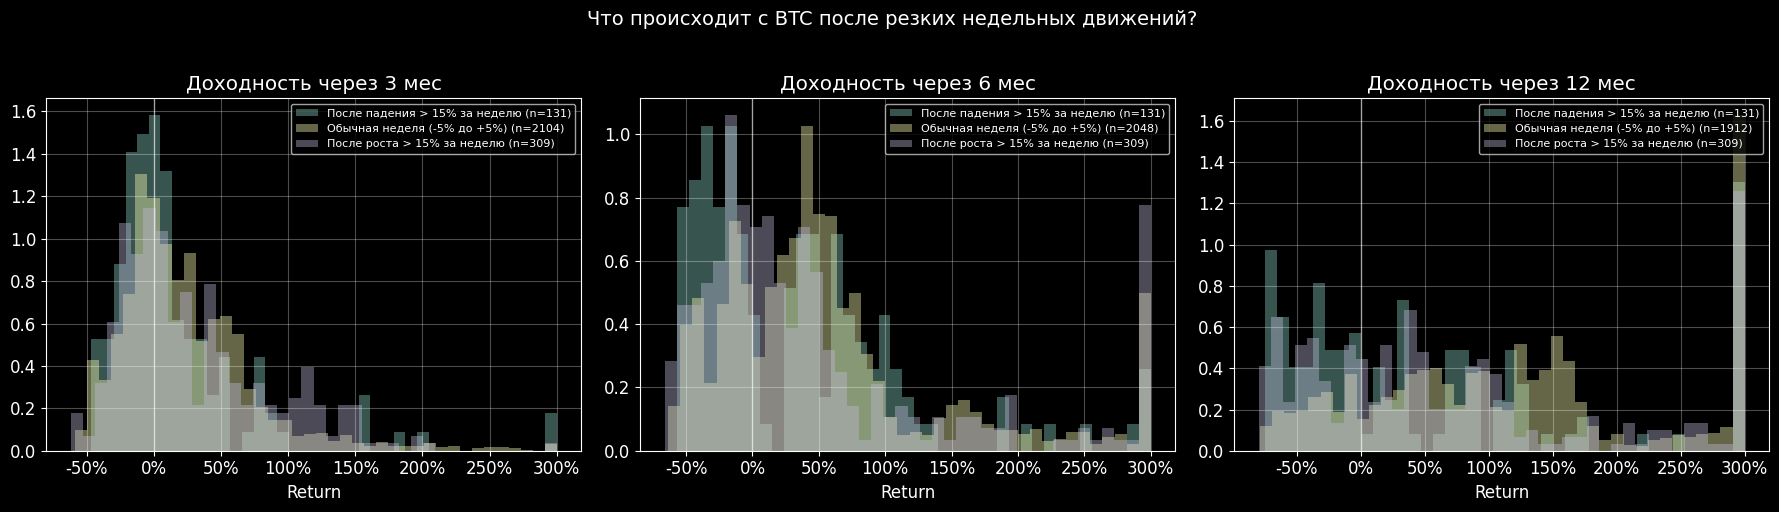

In [12]:
# Визуализация: распределение будущей доходности после падений vs после роста
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

conditions = {
    'После падения > 15% за неделю': btc_analysis['weekly_return'] <= -0.15,
    'Обычная неделя (-5% до +5%)': (btc_analysis['weekly_return'] > -0.05) & (btc_analysis['weekly_return'] < 0.05),
    'После роста > 15% за неделю': btc_analysis['weekly_return'] >= 0.15,
}

for idx, (h_name, h_days) in enumerate(horizons.items()):
    ax = axes[idx]
    col = f'future_{h_days}d'

    for cond_name, mask in conditions.items():
        data = btc_analysis.loc[mask, col].dropna()
        if len(data) > 10:
            data_clipped = data.clip(-0.8, 3.0)  # обрезаем для красоты графика
            ax.hist(data_clipped, bins=40, density=True, alpha=0.4, label=f'{cond_name} (n={len(data)})')

    ax.set_title(f'Доходность через {h_name}')
    ax.set_xlabel('Return')
    ax.axvline(x=0, color='white', linewidth=1, alpha=0.5)
    ax.legend(fontsize=8)
    ax.grid(alpha=0.3)
    ax.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

fig.suptitle('Что происходит с BTC после резких недельных движений?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In [13]:
# Ключевой вопрос: после падения 15%+ за неделю,
# какова вероятность достижения разных уровней от текущей цены?

crash_mask = btc_analysis['weekly_return'] <= -0.15
normal_mask = (btc_analysis['weekly_return'] > -0.05) & (btc_analysis['weekly_return'] < 0.05)

print("Вероятность роста от текущей цены через 6 месяцев:")
print(f"{'Уровень роста':>20s} {'После краша -15%':>18s} {'Обычная неделя':>18s} {'Разница':>10s}")
print("=" * 70)

for threshold in [0.0, 0.20, 0.40, 0.60, 0.80, 1.0, 1.5]:
    crash_data = btc_analysis.loc[crash_mask, 'future_180d'].dropna()
    normal_data = btc_analysis.loc[normal_mask, 'future_180d'].dropna()

    p_crash = (crash_data >= threshold).mean()
    p_normal = (normal_data >= threshold).mean()
    diff = p_crash - p_normal

    label = f"+{threshold:.0%}"
    print(f"{label:>20s} {p_crash:>17.1%} {p_normal:>17.1%} {diff:>+9.1%}")

print("\nВероятность падения от текущей цены через 6 месяцев:")
print(f"{'Уровень падения':>20s} {'После краша -15%':>18s} {'Обычная неделя':>18s} {'Разница':>10s}")
print("=" * 70)

for threshold in [-0.10, -0.20, -0.30, -0.40, -0.50]:
    p_crash = (crash_data <= threshold).mean()
    p_normal = (normal_data <= threshold).mean()
    diff = p_crash - p_normal

    label = f"{threshold:.0%}"
    print(f"{label:>20s} {p_crash:>17.1%} {p_normal:>17.1%} {diff:>+9.1%}")

Вероятность роста от текущей цены через 6 месяцев:
       Уровень роста   После краша -15%     Обычная неделя    Разница
                 +0%             52.7%             73.3%    -20.7%
                +20%             49.6%             65.0%    -15.4%
                +40%             38.9%             50.2%    -11.3%
                +60%             31.3%             33.4%     -2.1%
                +80%             20.6%             23.7%     -3.1%
               +100%             13.7%             17.9%     -4.1%
               +150%              6.9%             14.0%     -7.1%

Вероятность падения от текущей цены через 6 месяцев:
     Уровень падения   После краша -15%     Обычная неделя    Разница
                -10%             41.2%             21.6%    +19.6%
                -20%             31.3%             13.3%    +18.0%
                -30%             23.7%             10.9%    +12.8%
                -40%             13.7%              7.5%     +6.2%
                -5

## 8. Чувствительность к весам гипотез

Насколько результат зависит от наших предположений о μ?

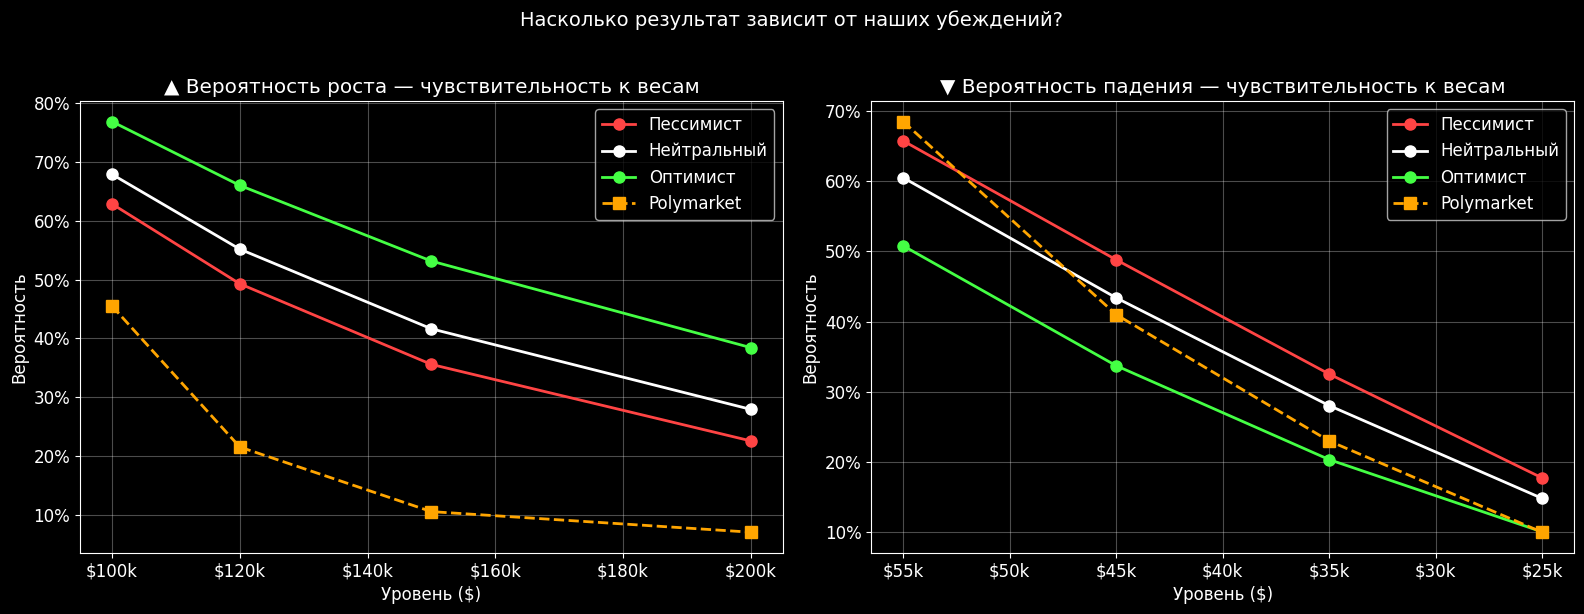

In [14]:
# Три сценария весов: пессимист, нейтральный, оптимист
weight_scenarios = {
    'Пессимист': [0.35, 0.30, 0.20, 0.10, 0.05],
    'Нейтральный': [0.20, 0.30, 0.25, 0.15, 0.10],  # наш текущий
    'Оптимист': [0.05, 0.15, 0.30, 0.30, 0.20],
}

# Ключевые уровни для проверки
key_levels_up = [100_000, 120_000, 150_000, 200_000]
key_levels_dn = [55_000, 45_000, 35_000, 25_000]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

scenario_colors = {'Пессимист': '#ff4444', 'Нейтральный': '#ffffff', 'Оптимист': '#44ff44'}

# Вверх
for sc_name, sc_weights in weight_scenarios.items():
    probs = []
    for level in key_levels_up:
        p_per_hyp = [np.mean(results[name]['max_price'] >= level) for name in MU_HYPOTHESES]
        weighted_p = sum(p * w for p, w in zip(p_per_hyp, sc_weights))
        probs.append(weighted_p)
    ax1.plot(key_levels_up, probs, 'o-', color=scenario_colors[sc_name],
             linewidth=2, markersize=8, label=sc_name)

pm_up = [POLYMARKET_PRICES['up'][l] for l in key_levels_up]
ax1.plot(key_levels_up, pm_up, 's--', color='orange', linewidth=2, markersize=8, label='Polymarket')
ax1.set_title('▲ Вероятность роста — чувствительность к весам')
ax1.set_xlabel('Уровень ($)')
ax1.set_ylabel('Вероятность')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

# Вниз
for sc_name, sc_weights in weight_scenarios.items():
    probs = []
    for level in key_levels_dn:
        p_per_hyp = [np.mean(results[name]['min_price'] <= level) for name in MU_HYPOTHESES]
        weighted_p = sum(p * w for p, w in zip(p_per_hyp, sc_weights))
        probs.append(weighted_p)
    ax2.plot(key_levels_dn, probs, 'o-', color=scenario_colors[sc_name],
             linewidth=2, markersize=8, label=sc_name)

pm_dn = [POLYMARKET_PRICES['down'][l] for l in key_levels_dn]
ax2.plot(key_levels_dn, pm_dn, 's--', color='orange', linewidth=2, markersize=8, label='Polymarket')
ax2.set_title('▼ Вероятность падения — чувствительность к весам')
ax2.set_xlabel('Уровень ($)')
ax2.set_ylabel('Вероятность')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

fig.suptitle('Насколько результат зависит от наших убеждений?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

## 9. Итоги: где edge?

Сводная таблица лучших возможностей.

In [15]:
# Сортируем по абсолютному edge
edges_sorted = sorted(edges, key=lambda x: abs(x[4]), reverse=True)

print("\n" + "=" * 95)
print("  ЛУЧШИЕ ВОЗМОЖНОСТИ σ(2015+) — отсортированы по APY")
print("=" * 95)
print(f"{'Контракт':>25s} {'Модель':>8s} {'Polym.':>8s} {'Edge':>7s} {'Цена':>7s} {'ROI':>7s} {'APY':>8s} {'Действие':>10s}")
print("-" * 95)

rows = []
for direction, level, model_p, pm_p, edge in edges_sorted:
    if abs(edge) < 0.01:
        continue
    if direction == 'up':
        contract = f"BTC > ${level:,}"
    else:
        contract = f"BTC < ${level:,}"

    if edge > 0:
        action = "BUY YES"
        buy_price = pm_p
    else:
        action = "BUY NO"
        buy_price = 1.0 - pm_p

    roi = abs(edge) / buy_price
    apy = roi * 365 / DAYS_LEFT
    rows.append((contract, model_p, pm_p, edge, buy_price, roi, apy, action))

# Сортируем по APY
rows.sort(key=lambda x: x[6], reverse=True)
for contract, model_p, pm_p, edge, buy_price, roi, apy, action in rows:
    print(f"{contract:>25s} {model_p:>7.1%} {pm_p:>7.1%} {edge:>+6.1%} {buy_price:>6.2f}  {roi:>+6.0%} {apy:>+7.0%}   {action:>8s}")

print(f"\n📅 Дней до экспирации: {DAYS_LEFT}")
print("💡 APY > 50% = отличный сигнал, 20-50% = хороший, <20% = слабый")
print("⚠️  ~2% комиссия Polymarket на покупку съедает часть edge!")


  ЛУЧШИЕ ВОЗМОЖНОСТИ σ(2015+) — отсортированы по APY
                 Контракт   Модель   Polym.    Edge    Цена     ROI      APY   Действие
-----------------------------------------------------------------------------------------------
           BTC > $170,000   35.2%    8.0% +27.2%   0.08   +339%   +379%    BUY YES
           BTC > $180,000   32.5%    7.5% +25.0%   0.07   +333%   +372%    BUY YES
           BTC > $250,000   19.9%    4.8% +15.2%   0.05   +319%   +356%    BUY YES
           BTC > $200,000   27.9%    7.0% +20.9%   0.07   +299%   +333%    BUY YES
           BTC > $150,000   41.6%   10.5% +31.1%   0.10   +296%   +331%    BUY YES
           BTC > $160,000   38.2%   10.0% +28.2%   0.10   +282%   +314%    BUY YES
           BTC > $190,000   30.1%    8.0% +22.1%   0.08   +276%   +308%    BUY YES
           BTC > $140,000   45.5%   14.5% +31.0%   0.14   +214%   +239%    BUY YES
           BTC > $130,000   50.0%   17.0% +33.0%   0.17   +194%   +217%    BUY YES
           BTC 

## 10. Проверка: σ за последние 2-3 года

Историческая σ с 2015 года включает дикий рост BTC ($200 → $124k). Волатильность тогда была выше.
Пересчитаем модель, используя только данные с 2023 года — более релевантный период для текущего рынка.

In [16]:
# Сравнение σ по периодам
periods = {
    'Всё время (2015-2026)': btc['log_return'],
    'Последние 3 года (2023-2026)': btc.loc['2023-01-01':, 'log_return'],
    'Последние 2 года (2024-2026)': btc.loc['2024-01-01':, 'log_return'],
    'Последний год (2025-2026)': btc.loc['2025-01-01':, 'log_return'],
}

print("=" * 85)
print(f"{'Период':>30s} {'Daily σ':>10s} {'Annual σ':>10s} {'Kurtosis':>10s} {'t-df':>8s} {'Дней':>8s}")
print("=" * 85)

for name, rets in periods.items():
    r = rets.values
    d_sigma = r.std()
    a_sigma = d_sigma * np.sqrt(365)
    kurt = stats.kurtosis(r)
    t_fit = stats.t.fit(r)
    print(f"{name:>30s} {d_sigma:.6f}   {a_sigma*100:>6.1f}%   {kurt:>8.2f}   {t_fit[0]:>6.2f}   {len(r):>6d}")

print("\nЕсли σ ниже → модель даёт меньшие вероятности → edge уменьшается")

                        Период    Daily σ   Annual σ   Kurtosis     t-df     Дней
         Всё время (2015-2026) 0.035500     67.8%      11.90     2.17     4054
  Последние 3 года (2023-2026) 0.024929     47.6%       3.58     2.89     1133
  Последние 2 года (2024-2026) 0.025932     49.5%       3.60     3.27      768
     Последний год (2025-2026) 0.024051     46.0%       6.19     3.04      402

Если σ ниже → модель даёт меньшие вероятности → edge уменьшается


In [17]:
# Пересчёт модели с σ за последние 3 года
recent_returns = btc.loc['2023-01-01':, 'log_return'].values
t_params_recent = stats.t.fit(recent_returns)
t_df_recent, t_loc_recent, t_scale_recent = t_params_recent

print(f"Student-t параметры (2023-2026 vs всё время):")
print(f"  df:    {t_df_recent:.2f}  (было {t_df:.2f})")
print(f"  scale: {t_scale_recent:.6f}  (было {t_scale:.6f})")
print(f"  Annual σ: {recent_returns.std() * np.sqrt(365) * 100:.1f}%  (было {returns.std() * np.sqrt(365) * 100:.1f}%)")

# Monte Carlo с новыми параметрами
results_recent = {}
all_paths_recent = {}

for name, mu in MU_HYPOTHESES.items():
    paths = simulate_paths(CURRENT_PRICE, DAYS_LEFT, N_SIMULATIONS, mu, t_df_recent, t_scale_recent)
    all_paths_recent[name] = paths
    results_recent[name] = {
        'max_price': np.max(paths, axis=1),
        'min_price': np.min(paths, axis=1),
        'final_price': paths[:, -1],
    }

print("\nСимуляция с σ(2023-2026) завершена!")

Student-t параметры (2023-2026 vs всё время):
  df:    2.89  (было 2.17)
  scale: 0.015895  (было 0.018482)
  Annual σ: 47.6%  (было 67.8%)

Симуляция с σ(2023-2026) завершена!


### 10.1 Траектории (σ 2023+)

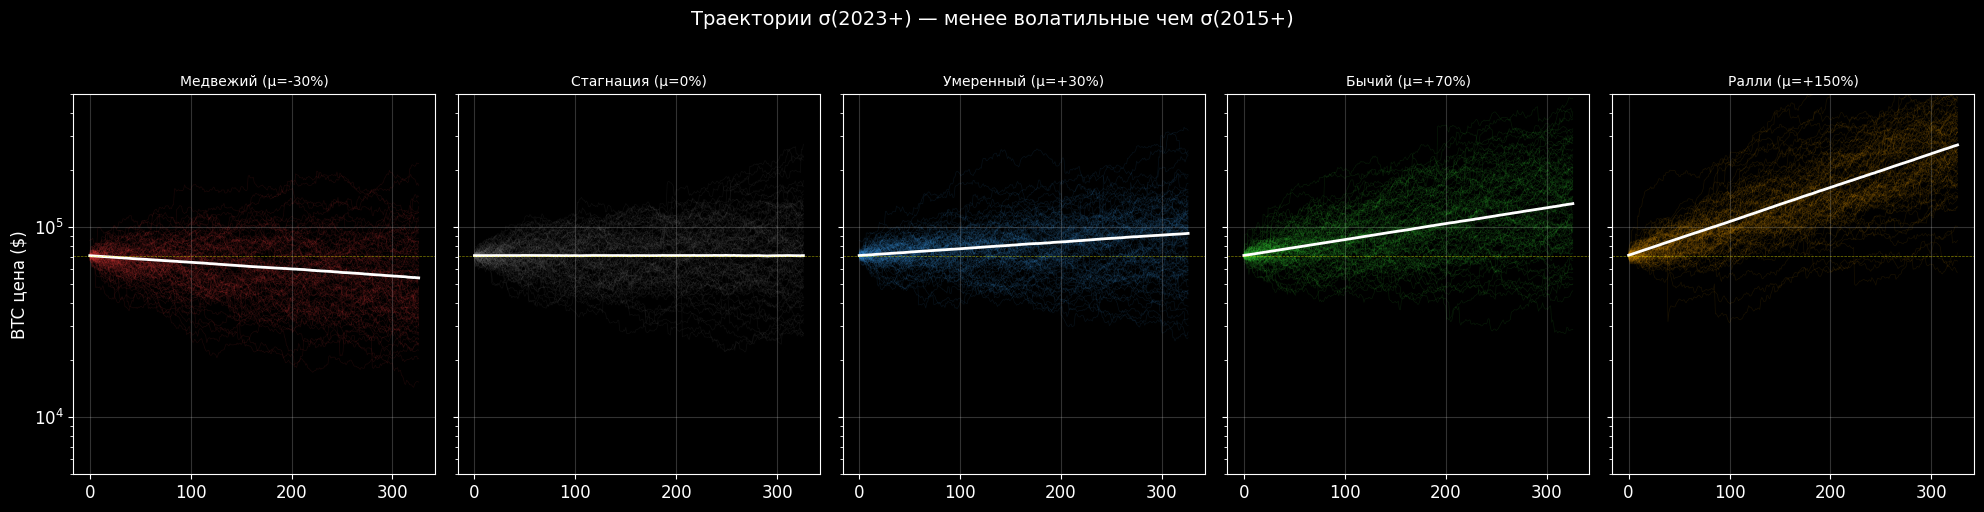

In [18]:
# Траектории для модели σ(2023+)
fig, axes = plt.subplots(1, len(MU_HYPOTHESES), figsize=(20, 5), sharey=True)
colors = ['#ff4444', '#888888', '#44aaff', '#44ff44', '#ffaa00']

for idx, (name, paths) in enumerate(all_paths_recent.items()):
    ax = axes[idx]
    sample_idx = np.random.choice(N_SIMULATIONS, 100, replace=False)
    for i in sample_idx:
        ax.plot(paths[i], color=colors[idx], alpha=0.1, linewidth=0.5)
    median_path = np.median(paths, axis=0)
    ax.plot(median_path, color='white', linewidth=2, label='Медиана')
    ax.axhline(y=CURRENT_PRICE, color='yellow', linewidth=0.5, linestyle='--', alpha=0.5)
    ax.set_title(name, fontsize=10)
    ax.set_yscale('log')
    ax.set_ylim(5000, 500000)
    ax.grid(alpha=0.2)
    if idx == 0:
        ax.set_ylabel('BTC цена ($)')

fig.suptitle('Траектории σ(2023+) — менее волатильные чем σ(2015+)', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 10.2 Touch probabilities (σ 2023+)

In [19]:
# Touch probabilities для σ(2023+)
print(f"{'':30s}", end='')
for name in MU_HYPOTHESES:
    short = name.split('(')[0].strip()
    print(f"{short:>12s}", end='')
print(f"{'Взвешенное':>12s}  {'Polymarket':>11s}  {'Edge':>7s}")
print("=" * 120)

edges_recent = []

print("\n  ▲ Рост (touch max) — σ(2023+)")
for level in sorted(POLYMARKET_PRICES['up'].keys()):
    pm_price = POLYMARKET_PRICES['up'][level]
    probs = []
    print(f"  BTC > ${level:>7,}:  ", end='')
    for name in MU_HYPOTHESES:
        p = np.mean(results_recent[name]['max_price'] >= level)
        probs.append(p)
        print(f"{p:>11.1%} ", end='')
    weights = list(MU_WEIGHTS.values())
    weighted = sum(p * w for p, w in zip(probs, weights))
    edge = weighted - pm_price
    edges_recent.append(('up', level, weighted, pm_price, edge))
    edge_color = '🟢' if edge > 0.03 else ('🔴' if edge < -0.03 else '⚪')
    print(f"{weighted:>11.1%}  {pm_price:>10.1%}  {edge:>+6.1%} {edge_color}")

print("\n  ▼ Падение (touch min) — σ(2023+)")
for level in sorted(POLYMARKET_PRICES['down'].keys(), reverse=True):
    pm_price = POLYMARKET_PRICES['down'][level]
    probs = []
    print(f"  BTC < ${level:>7,}:  ", end='')
    for name in MU_HYPOTHESES:
        p = np.mean(results_recent[name]['min_price'] <= level)
        probs.append(p)
        print(f"{p:>11.1%} ", end='')
    weights = list(MU_WEIGHTS.values())
    weighted = sum(p * w for p, w in zip(probs, weights))
    edge = weighted - pm_price
    edges_recent.append(('down', level, weighted, pm_price, edge))
    edge_color = '🟢' if edge > 0.03 else ('🔴' if edge < -0.03 else '⚪')
    print(f"{weighted:>11.1%}  {pm_price:>10.1%}  {edge:>+6.1%} {edge_color}")

print("\n🟢 = модель выше рынка (покупать YES), 🔴 = модель ниже рынка (покупать NO)")

                                  Медвежий   Стагнация   Умеренный       Бычий       Ралли  Взвешенное   Polymarket     Edge

  ▲ Рост (touch max) — σ(2023+)
  BTC > $ 75,000:        77.5%       87.0%       93.7%       98.1%       99.9%       89.7%       83.5%   +6.2% 🟢
  BTC > $ 80,000:        63.0%       76.4%       87.8%       96.0%       99.8%       81.9%       74.0%   +7.9% 🟢
  BTC > $ 90,000:        42.2%       59.2%       75.6%       90.6%       99.5%       68.6%       62.0%   +6.6% 🟢
  BTC > $100,000:        28.7%       45.7%       64.2%       84.5%       98.9%       58.1%       45.5%  +12.6% 🟢
  BTC > $110,000:        19.9%       34.9%       53.8%       77.7%       98.1%       49.3%       33.5%  +15.8% 🟢
  BTC > $120,000:        14.0%       26.6%       44.8%       70.8%       97.0%       42.3%       21.5%  +20.8% 🟢
  BTC > $130,000:         9.9%       20.5%       37.1%       63.8%       95.6%       36.5%       17.0%  +19.5% 🟢
  BTC > $140,000:         7.1%       16.0%       30

### 10.3 Модель vs Polymarket (σ 2023+)

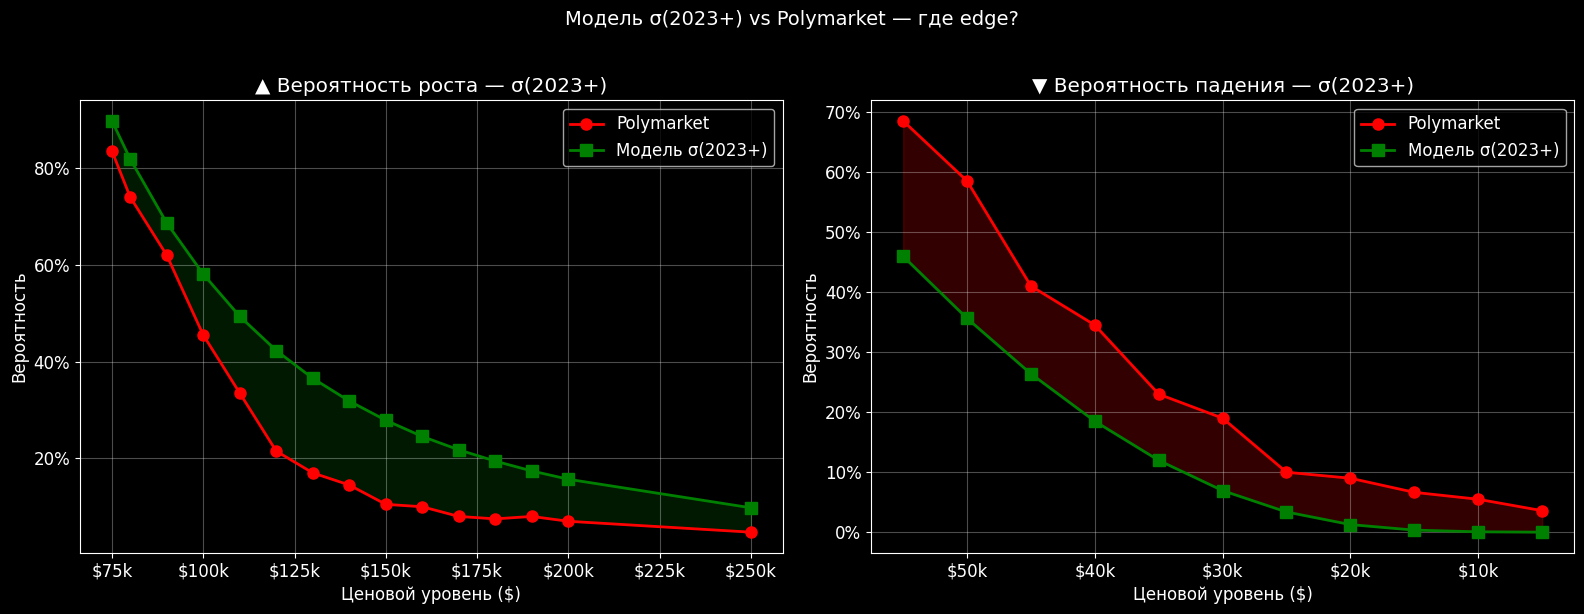

In [20]:
# Модель σ(2023+) vs Polymarket
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

up_levels = sorted(POLYMARKET_PRICES['up'].keys())
up_pm = [POLYMARKET_PRICES['up'][l] for l in up_levels]
up_model_r = [next(e[2] for e in edges_recent if e[0]=='up' and e[1]==l) for l in up_levels]

ax1.plot(up_levels, up_pm, 'ro-', linewidth=2, markersize=8, label='Polymarket')
ax1.plot(up_levels, up_model_r, 'gs-', linewidth=2, markersize=8, label='Модель σ(2023+)')
ax1.fill_between(up_levels, up_pm, up_model_r, alpha=0.2,
                  color='green', where=[m > p for m, p in zip(up_model_r, up_pm)])
ax1.fill_between(up_levels, up_pm, up_model_r, alpha=0.2,
                  color='red', where=[m < p for m, p in zip(up_model_r, up_pm)])
ax1.set_title('▲ Вероятность роста — σ(2023+)')
ax1.set_xlabel('Ценовой уровень ($)')
ax1.set_ylabel('Вероятность')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

dn_levels = sorted(POLYMARKET_PRICES['down'].keys(), reverse=True)
dn_pm = [POLYMARKET_PRICES['down'][l] for l in dn_levels]
dn_model_r = [next(e[2] for e in edges_recent if e[0]=='down' and e[1]==l) for l in dn_levels]

ax2.plot(dn_levels, dn_pm, 'ro-', linewidth=2, markersize=8, label='Polymarket')
ax2.plot(dn_levels, dn_model_r, 'gs-', linewidth=2, markersize=8, label='Модель σ(2023+)')
ax2.fill_between(dn_levels, dn_pm, dn_model_r, alpha=0.2,
                  color='green', where=[m > p for m, p in zip(dn_model_r, dn_pm)])
ax2.fill_between(dn_levels, dn_pm, dn_model_r, alpha=0.2,
                  color='red', where=[m < p for m, p in zip(dn_model_r, dn_pm)])
ax2.set_title('▼ Вероятность падения — σ(2023+)')
ax2.set_xlabel('Ценовой уровень ($)')
ax2.set_ylabel('Вероятность')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

fig.suptitle('Модель σ(2023+) vs Polymarket — где edge?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 10.4 Implied vs Model Distribution (σ 2023+)

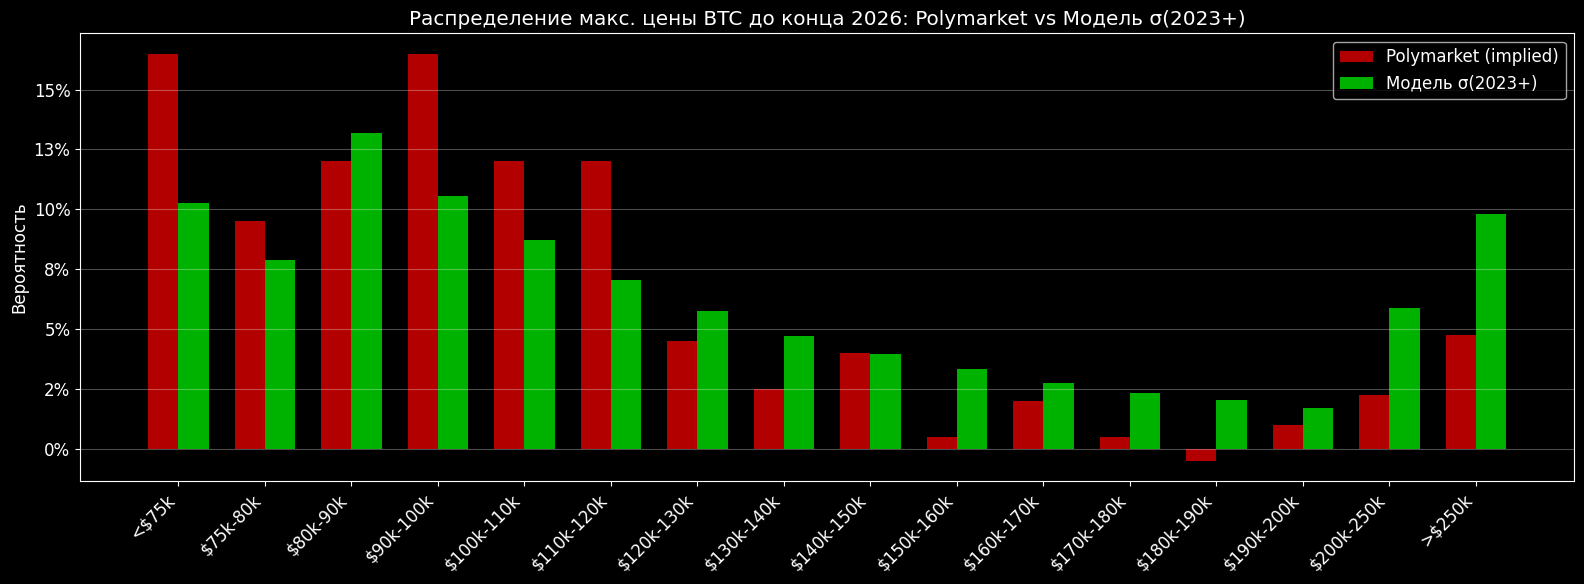

In [21]:
# Implied vs Model distribution — σ(2023+)
all_levels_up = sorted(POLYMARKET_PRICES['up'].keys())
weights = list(MU_WEIGHTS.values())

# Implied density (из Polymarket, не меняется)
implied_ranges_up = []
for i in range(len(all_levels_up)):
    if i == 0:
        p = 1.0 - POLYMARKET_PRICES['up'][all_levels_up[0]]
    else:
        p = POLYMARKET_PRICES['up'][all_levels_up[i-1]] - POLYMARKET_PRICES['up'][all_levels_up[i]]
    implied_ranges_up.append(p)
implied_ranges_up.append(POLYMARKET_PRICES['up'][all_levels_up[-1]])

# Model density — σ(2023+)
model_ranges_up_recent = []
for i in range(len(all_levels_up)):
    if i == 0:
        probs = [1.0 - np.mean(results_recent[name]['max_price'] >= all_levels_up[0]) for name in MU_HYPOTHESES]
    else:
        probs = [np.mean(results_recent[name]['max_price'] >= all_levels_up[i-1]) -
                 np.mean(results_recent[name]['max_price'] >= all_levels_up[i]) for name in MU_HYPOTHESES]
    model_ranges_up_recent.append(sum(p * w for p, w in zip(probs, weights)))
probs = [np.mean(results_recent[name]['max_price'] >= all_levels_up[-1]) for name in MU_HYPOTHESES]
model_ranges_up_recent.append(sum(p * w for p, w in zip(probs, weights)))

labels_up = [f'<${all_levels_up[0]//1000}k'] + \
            [f'${all_levels_up[i]//1000}k-{all_levels_up[i+1]//1000}k' for i in range(len(all_levels_up)-1)] + \
            [f'>${all_levels_up[-1]//1000}k']

x_pos = np.arange(len(labels_up))
width = 0.35

fig, ax = plt.subplots(figsize=(16, 6))
ax.bar(x_pos - width/2, implied_ranges_up, width, color='red', alpha=0.7, label='Polymarket (implied)')
ax.bar(x_pos + width/2, model_ranges_up_recent, width, color='lime', alpha=0.7, label='Модель σ(2023+)')

ax.set_title('Распределение макс. цены BTC до конца 2026: Polymarket vs Модель σ(2023+)')
ax.set_ylabel('Вероятность')
ax.set_xticks(x_pos)
ax.set_xticklabels(labels_up, rotation=45, ha='right')
ax.legend()
ax.grid(alpha=0.3, axis='y')
ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

plt.tight_layout()
plt.show()

### 10.5 Чувствительность к весам (σ 2023+)

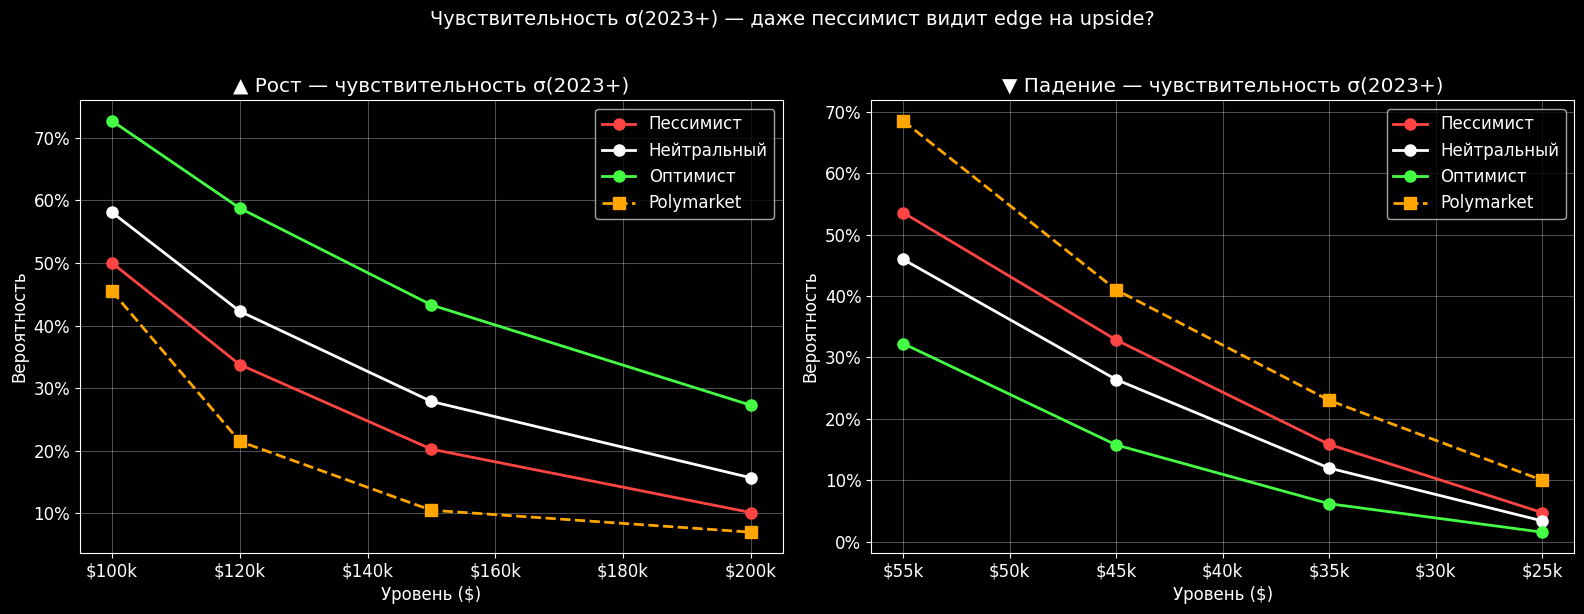

In [22]:
# Чувствительность к весам — σ(2023+)
weight_scenarios = {
    'Пессимист': [0.35, 0.30, 0.20, 0.10, 0.05],
    'Нейтральный': [0.20, 0.30, 0.25, 0.15, 0.10],
    'Оптимист': [0.05, 0.15, 0.30, 0.30, 0.20],
}
key_levels_up = [100_000, 120_000, 150_000, 200_000]
key_levels_dn = [55_000, 45_000, 35_000, 25_000]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
scenario_colors = {'Пессимист': '#ff4444', 'Нейтральный': '#ffffff', 'Оптимист': '#44ff44'}

for sc_name, sc_weights in weight_scenarios.items():
    probs = []
    for level in key_levels_up:
        p_per_hyp = [np.mean(results_recent[name]['max_price'] >= level) for name in MU_HYPOTHESES]
        probs.append(sum(p * w for p, w in zip(p_per_hyp, sc_weights)))
    ax1.plot(key_levels_up, probs, 'o-', color=scenario_colors[sc_name], linewidth=2, markersize=8, label=sc_name)

pm_up = [POLYMARKET_PRICES['up'][l] for l in key_levels_up]
ax1.plot(key_levels_up, pm_up, 's--', color='orange', linewidth=2, markersize=8, label='Polymarket')
ax1.set_title('▲ Рост — чувствительность σ(2023+)')
ax1.set_xlabel('Уровень ($)')
ax1.set_ylabel('Вероятность')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

for sc_name, sc_weights in weight_scenarios.items():
    probs = []
    for level in key_levels_dn:
        p_per_hyp = [np.mean(results_recent[name]['min_price'] <= level) for name in MU_HYPOTHESES]
        probs.append(sum(p * w for p, w in zip(p_per_hyp, sc_weights)))
    ax2.plot(key_levels_dn, probs, 'o-', color=scenario_colors[sc_name], linewidth=2, markersize=8, label=sc_name)

pm_dn = [POLYMARKET_PRICES['down'][l] for l in key_levels_dn]
ax2.plot(key_levels_dn, pm_dn, 's--', color='orange', linewidth=2, markersize=8, label='Polymarket')
ax2.set_title('▼ Падение — чувствительность σ(2023+)')
ax2.set_xlabel('Уровень ($)')
ax2.set_ylabel('Вероятность')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

fig.suptitle('Чувствительность σ(2023+) — даже пессимист видит edge на upside?', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

### 10.6 Сравнение двух моделей + итоговая таблица edge

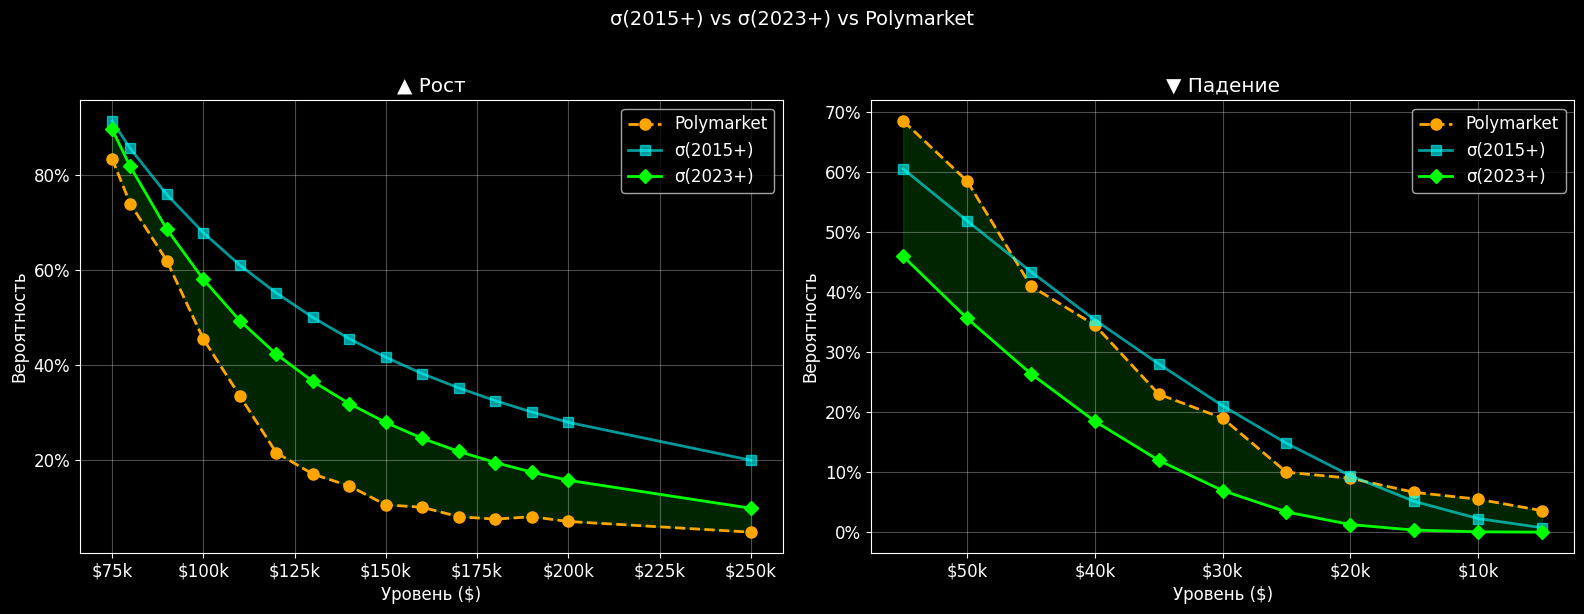


  ЛУЧШИЕ ВОЗМОЖНОСТИ σ(2023+) — отсортированы по APY
                 Контракт   Модель   Polym.    Edge    Цена     ROI      APY   Действие
-----------------------------------------------------------------------------------------------
           BTC > $170,000   21.8%    8.0% +13.8%   0.08   +172%   +192%    BUY YES
           BTC > $150,000   27.9%   10.5% +17.4%   0.10   +165%   +185%    BUY YES
           BTC > $180,000   19.4%    7.5% +11.9%   0.07   +159%   +178%    BUY YES
           BTC > $160,000   24.5%   10.0% +14.5%   0.10   +145%   +162%    BUY YES
           BTC > $200,000   15.7%    7.0%  +8.7%   0.07   +124%   +138%    BUY YES
           BTC > $140,000   31.8%   14.5% +17.3%   0.14   +120%   +134%    BUY YES
           BTC > $190,000   17.4%    8.0%  +9.4%   0.08   +118%   +131%    BUY YES
           BTC > $130,000   36.5%   17.0% +19.5%   0.17   +115%   +128%    BUY YES
           BTC > $250,000    9.8%    4.8%  +5.0%   0.05   +106%   +118%    BUY YES
           BTC 

In [23]:
# Сравнение: σ(2015+) vs σ(2023+) vs Polymarket — три линии
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

up_levels = sorted(POLYMARKET_PRICES['up'].keys())
up_pm = [POLYMARKET_PRICES['up'][l] for l in up_levels]
up_full = [next(e[2] for e in edges if e[0]=='up' and e[1]==l) for l in up_levels]
up_rec = [next(e[2] for e in edges_recent if e[0]=='up' and e[1]==l) for l in up_levels]

ax1.plot(up_levels, up_pm, 'o--', color='orange', linewidth=2, markersize=8, label='Polymarket')
ax1.plot(up_levels, up_full, 's-', color='cyan', linewidth=2, markersize=7, label='σ(2015+)', alpha=0.6)
ax1.plot(up_levels, up_rec, 'D-', color='lime', linewidth=2, markersize=7, label='σ(2023+)')
ax1.fill_between(up_levels, up_pm, up_rec, alpha=0.15, color='lime')
ax1.set_title('▲ Рост')
ax1.set_xlabel('Уровень ($)')
ax1.set_ylabel('Вероятность')
ax1.legend()
ax1.grid(alpha=0.3)
ax1.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

dn_levels = sorted(POLYMARKET_PRICES['down'].keys(), reverse=True)
dn_pm = [POLYMARKET_PRICES['down'][l] for l in dn_levels]
dn_full = [next(e[2] for e in edges if e[0]=='down' and e[1]==l) for l in dn_levels]
dn_rec = [next(e[2] for e in edges_recent if e[0]=='down' and e[1]==l) for l in dn_levels]

ax2.plot(dn_levels, dn_pm, 'o--', color='orange', linewidth=2, markersize=8, label='Polymarket')
ax2.plot(dn_levels, dn_full, 's-', color='cyan', linewidth=2, markersize=7, label='σ(2015+)', alpha=0.6)
ax2.plot(dn_levels, dn_rec, 'D-', color='lime', linewidth=2, markersize=7, label='σ(2023+)')
ax2.fill_between(dn_levels, dn_pm, dn_rec, alpha=0.15, color='lime')
ax2.set_title('▼ Падение')
ax2.set_xlabel('Уровень ($)')
ax2.set_ylabel('Вероятность')
ax2.legend()
ax2.grid(alpha=0.3)
ax2.invert_xaxis()
ax2.xaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x/1000:.0f}k'))
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.0%}'))

fig.suptitle('σ(2015+) vs σ(2023+) vs Polymarket', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Итоговая таблица edge для σ(2023+) с APY
edges_recent_sorted = sorted(edges_recent, key=lambda x: abs(x[4]), reverse=True)

print("\n" + "=" * 95)
print("  ЛУЧШИЕ ВОЗМОЖНОСТИ σ(2023+) — отсортированы по APY")
print("=" * 95)
print(f"{'Контракт':>25s} {'Модель':>8s} {'Polym.':>8s} {'Edge':>7s} {'Цена':>7s} {'ROI':>7s} {'APY':>8s} {'Действие':>10s}")
print("-" * 95)

rows = []
for direction, level, model_p, pm_p, edge in edges_recent_sorted:
    if abs(edge) < 0.01:
        continue
    if direction == 'up':
        contract = f"BTC > ${level:,}"
    else:
        contract = f"BTC < ${level:,}"

    if edge > 0:
        action = "BUY YES"
        buy_price = pm_p
    else:
        action = "BUY NO"
        buy_price = 1.0 - pm_p

    roi = abs(edge) / buy_price
    apy = roi * 365 / DAYS_LEFT
    rows.append((contract, model_p, pm_p, edge, buy_price, roi, apy, action))

rows.sort(key=lambda x: x[6], reverse=True)
for contract, model_p, pm_p, edge, buy_price, roi, apy, action in rows:
    print(f"{contract:>25s} {model_p:>7.1%} {pm_p:>7.1%} {edge:>+6.1%} {buy_price:>6.2f}  {roi:>+6.0%} {apy:>+7.0%}   {action:>8s}")

print(f"\n📅 Дней до экспирации: {DAYS_LEFT}")
print("💡 APY > 50% = отличный сигнал, 20-50% = хороший, <20% = слабый")
print("⚠️  σ(2023+) — более консервативная оценка. ~2% комиссия съедает часть edge.")